<a href="https://colab.research.google.com/github/Vishnu-3101/BitcoinResearch/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
custom_stop_words = {'bitcoin','btc','de','la','en'}
english_stopwords = set(stopwords.words('english'))
french_stopwords = set(stopwords.words('french'))
stop_words = english_stopwords.union(french_stopwords)
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
class TweetsDataset:
    def __init__(self,dataset_path):
        self.tweets = pd.read_csv(dataset_path)

    def group_dataset_by_date(self):
        self.tweets['date'] = pd.to_datetime(self.tweets['date'])
        self.tweets = self.tweets.sort_values(by='date',na_position='first')
        self.tweets = self.tweets.dropna()
        self.aggregated_tweets = self.tweets.groupby('date')['text_split'].agg(lambda x: ' '.join(x)).reset_index()
        return self.aggregated_tweets

    def preprocessing(self,data):
        for i,t in enumerate(tqdm(data['text_split'])):
            text = str(data.loc[i,'text_split'])
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = text.lower()
            text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])
            text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
            data.loc[i,'text_split'] = text
        return data

    def word_cloud(self,data):
        word_cloud = WordCloud(width = 800, height=600, max_words = 200, background_color='white',collocations=False).generate(' '.join(data))
        plt.figure(figsize = (10,8))
        plt.imshow(word_cloud,interpolation = 'bilinear')
        plt.axis('off')
        plt.show()

    def top_20_words(self,data):
        all_words = ' '.join(data).split()
        word_freq = nltk.FreqDist(all_words)
        word_freq_df = pd.DataFrame(list(word_freq.items()),columns=['word','frequency']).sort_values(by='frequency',ascending = False)
        plt.figure(figsize = (10,8))
        sns.barplot(x='frequency',y='word',data=word_freq_df.head(20))
        plt.title('Top 20 words in the corpus')
        plt.show()

    def visualize_by_volume(self):
        self.tweets_per_day = self.tweets.groupby(self.tweets['date'].dt.date)['text_split'].count().reset_index()
        self.tweets_per_day.columns = ['Date', 'Tweets_Count']
        plt.figure(figsize=(12, 5))
        sns.lineplot(x='Date', y=self.tweets_per_day['Tweets_Count'], data=self.tweets_per_day)
        plt.title('Tweet Volume Over Time')
        plt.xlabel('Date')
        plt.ylabel('Tweet Count')
        plt.show()

    def correlation(self,x,y):
        correlation_coefficient, p_value = pearsonr(x, y)

        # Display the correlation coefficient and p-value
        print(f"Correlation Coefficient: {correlation_coefficient}")
        print(f"P-value: {p_value}")

        # Scatter plot to visualize the relationship
        plt.scatter(x, y)
        plt.title('Scatter Plot: Tweets Count vs. Price')
        plt.xlabel('Number of Tweets per Day')
        plt.ylabel('Bitcoin Price')
        plt.show()

    def get_5day_data(self,data):
        dataset = []

        # Iterate through the data to create the dataset with 5-day lag
        for i in range(5, len(data)):
            # Extract the tweets for the current day and the past 4 days
            tweets_window = data['text_split'].iloc[i-5:i].tolist()
            # Append the data to the dataset
            dataset.append([tweets for tweets in tweets_window])

        # Convert the dataset to a DataFrame for further analysis if needed
        columns = ['Tweets_Day_1', 'Tweets_Day_2', 'Tweets_Day_3', 'Tweets_Day_4', 'Tweets_Day_5']
        dataset_df = pd.DataFrame(dataset, columns=columns)
        return dataset_df


In [5]:
dataset_path = '/content/drive/MyDrive/ResearchPaper/Dataset/tweets/combined_tweets_2015_labeled.csv'
tweets = TweetsDataset(dataset_path)

In [6]:
aggregated_data = tweets.group_dataset_by_date()

In [7]:
aggregated_data = tweets.preprocessing(aggregated_data)

100%|██████████| 364/364 [00:33<00:00, 10.87it/s]


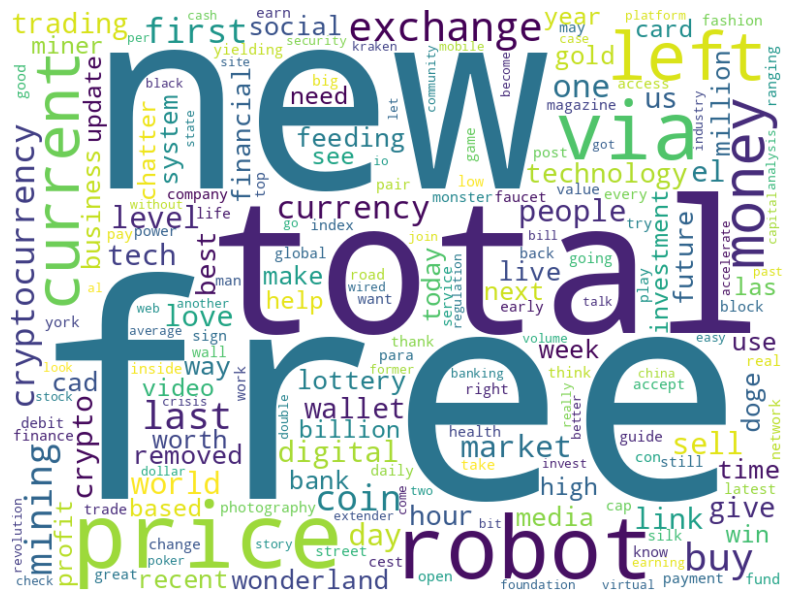

In [8]:
tweets.word_cloud(aggregated_data['text_split'])

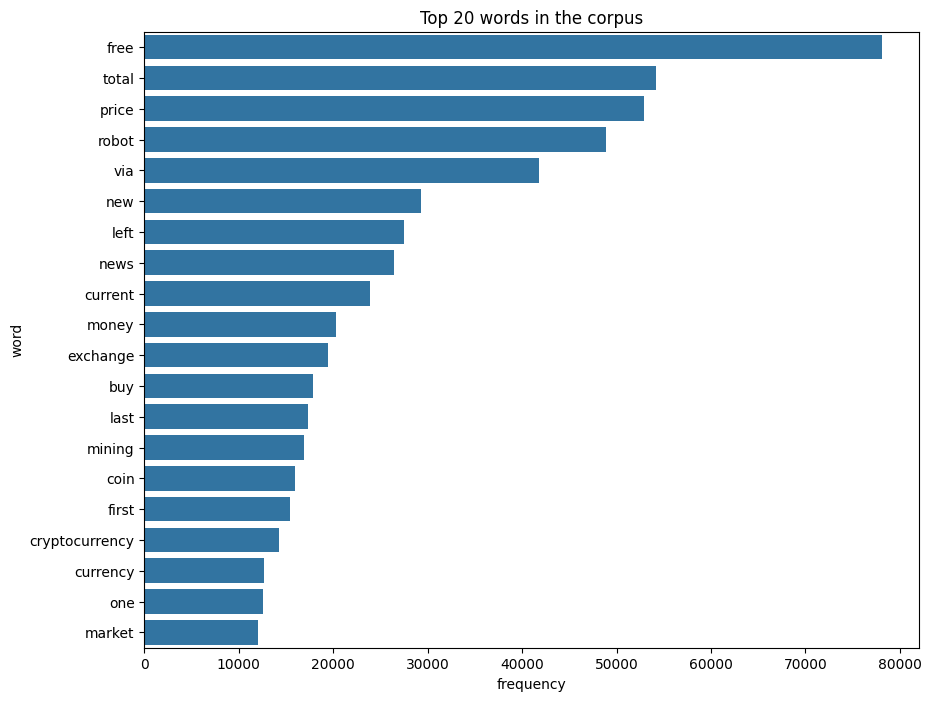

In [9]:
tweets.top_20_words(aggregated_data['text_split'])

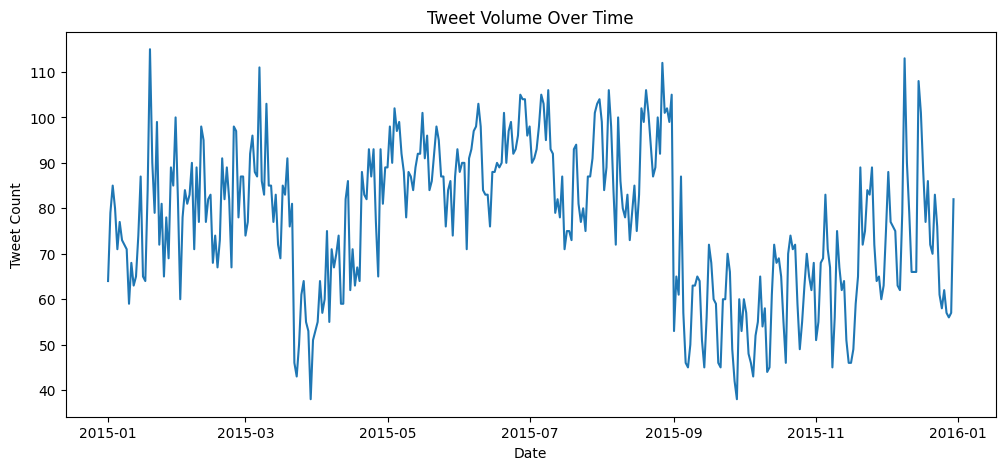

In [10]:
tweets.visualize_by_volume()

In [11]:
data_5day = tweets.get_5day_data(aggregated_data)
data_5day.head()

,Tweets_Day_1,Tweets_Day_2,Tweets_Day_3,Tweets_Day_4,Tweets_Day_5
0,blocked thats achievement still like ser patri...,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...
1,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...
2,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...
3,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...
4,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...,founder twitter working alongside team san pro...


In [12]:
class BTC_data:
  def __init__(self,dataset_path):
    self.btc_data = pd.read_csv(dataset_path)

  def normalize(self,data):
    columns_to_normalize = ['Open','High','Low','Close','Adj Close','Volume']
    scaler = MinMaxScaler()
    data_to_normalize = data.loc[:,columns_to_normalize]
    normalized_data =  scaler.fit_transform(data_to_normalize)
    normalized_data = pd.DataFrame(normalized_data,columns=columns_to_normalize)
    data = pd.concat([data.drop(columns=columns_to_normalize),normalized_data],axis=1)
    return data

In [13]:
btc_data_path = '/content/drive/MyDrive/ResearchPaper/Dataset/BTC_data/BTC-USD_2015.csv'
BTC = BTC_data(btc_data_path)
btc_data =BTC.btc_data

In [14]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [15]:
normalized_data = BTC.normalize(btc_data)
normalized_data = normalized_data.drop('Date',axis=1)
normalized_data.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.497858,0.382988,0.499528,0.474016,0.474016,0.000687
1,0.475813,0.366796,0.497993,0.476742,0.476742,0.000000
2,0.478473,0.364368,0.384119,0.358539,0.358539,0.098398
3,0.361585,0.266000,0.301842,0.299744,0.299744,0.186567
4,0.305875,0.234682,0.328036,0.335533,0.335533,0.141002


Correlation Coefficient: -0.12564665034547004
P-value: 0.016464513386851936


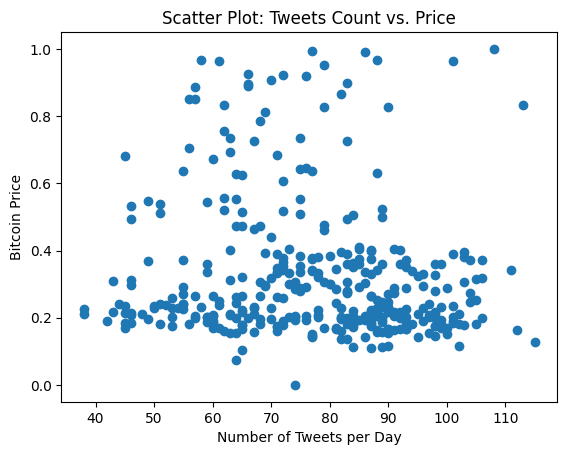

In [16]:
tweets.correlation(tweets.tweets_per_day['Tweets_Count'], normalized_data['Close'][:364])

In [17]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print("Training on device: ", device)

Training on device:  cuda


In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # You can adjust max_features as needed
# encoded_tweets = vectorizer.fit_transform(aggregated_data['text_split'])

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# tokenizer = LlamaTokenizer.from_pretrained("/output/path")
# model = LlamaForCausalLM.from_pretrained("/output/path")

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, output_size):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # Calculate the number of features after convolutional layers
        # This depends on the input size and the kernel sizes used
        self.fc_input_size = self.calculate_fc_input_size(input_channels, [self.conv1, self.conv2])

        self.fc1 = nn.Linear(6080, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # print(x.shape)
        # Flatten the output before passing it to fully connected layers
        x = x.view(-1, 6080)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def calculate_fc_input_size(self, input_channels, conv_layers):
        # Calculate the number of features after convolutional layers
        # This is needed to determine the input size for fully connected layers
        with torch.no_grad():
            x = torch.zeros(1, input_channels, 768)
            for layer in conv_layers:
                x = layer(x)
            return x.view(1, -1).size(1)

In [21]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(512*1536, 32, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(32, 16, batch_first=True, dropout=0.45)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.lstm3 = nn.LSTM(16, 8, batch_first=True)
        self.batch_norm2 = nn.BatchNorm1d(8)
        self.lstm4 = nn.LSTM(8, 1, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = nn.functional.dropout(out, p=0.3, training=self.training)
        out, _ = self.lstm2(out)
        out = nn.functional.dropout(out, p=0.45, training=self.training)
        out = self.batch_norm1(out)
        out, _ = self.lstm3(out)
        out = self.batch_norm2(out)
        out = nn.functional.dropout(out, p=0.45, training=self.training)
        out, _ = self.lstm4(out)
        return out

In [22]:
input_channels = 512
output_size = 1
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# word_embeddings = []
# for i in tqdm(range(len(data_5day))):
#       label = normalized_data.iloc[i]['Close']

#       input = []
#       output = []

#       encoding = tokenizer.batch_encode_plus(
#           data_5day.iloc[i],
#           padding=True,
#           truncation=True,
#           return_tensors='pt',
#           add_special_tokens=True
#       )

#       bert_outputs = bert_model(encoding.input_ids.to(device), attention_mask=encoding.attention_mask.to(device)).last_hidden_state
#       word_embeddings.append(bert_outputs)

In [ ]:
def train_model(path,epochs):
    # epochs = 30
    # path = '/content/drive/MyDrive/ResearchPaper/Results/train.csv'
    df_train = pd.DataFrame(columns = ['epoch', 'MSE_loss'])
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for i in tqdm(range(len(data_5day))):
          label = normalized_data.iloc[i]['Close']

          input = []
          output = []

          encoding = tokenizer.batch_encode_plus(
              data_5day.iloc[i],
              padding=True,
              truncation=True,
              return_tensors='pt',
              add_special_tokens=True
          )

          bert_outputs = bert_model(encoding.input_ids.to(device), attention_mask=encoding.attention_mask.to(device)).last_hidden_state
          window = normalized_data.iloc[i:i+5].values
          # print(window.shape)
          conv1 = nn.Conv1d(6, 768, kernel_size=1)
          conv2 = nn.Conv1d(1, 512, kernel_size=1)

          btc_data_reshaped = torch.from_numpy(window).unsqueeze(2).permute(0, 1, 2).float()
          # print(btc_data_reshaped.shape)
          btc_data_transformed = conv1(btc_data_reshaped)
          btc_data_transformed = btc_data_transformed.permute(0, 2, 1)
          btc_data_transformed = conv2(btc_data_transformed).to(device)
          # print(btc_data_transformed.shape)
          concatenated_data = torch.cat([bert_outputs, btc_data_transformed], dim=-1)
          shape = concatenated_data.shape
          # print(shape)
          concatenated_data = concatenated_data.reshape(shape[0],shape[1]*shape[2])

          output = torch.full((5,), label).view(-1, 1)

          # for tweet in data_5day.iloc[i]:
          #   tokens = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
          #   with torch.no_grad():
          #       bert_outputs = bert_model(**tokens)

          optimizer.zero_grad()
          model_output = model(concatenated_data)
          loss = criterion(model_output.to(device), output.to(device))
          loss.backward()
          optimizer.step()
          running_loss+=loss
        #   break


        epoch_loss = running_loss/len(data_5day)

        df_new_row = pd.DataFrame({ 'epoch': [epoch], 'train_loss': [epoch_loss.cpu().detach().numpy()]})
        df_train = pd.concat([df_train, df_new_row])
        df_train.to_csv(path)
        print("MSE: {:.4f}".format(epoch_loss)).
        return model

          # print(['Tweets_Day_1'])

100%|██████████| 359/359 [07:06<00:00,  1.19s/it]


MSE: 0.6971


100%|██████████| 359/359 [06:56<00:00,  1.16s/it]


MSE: 0.4839


100%|██████████| 359/359 [06:58<00:00,  1.17s/it]


MSE: 0.3634


100%|██████████| 359/359 [06:56<00:00,  1.16s/it]


MSE: 0.2977


100%|██████████| 359/359 [06:58<00:00,  1.17s/it]


MSE: 0.3245


100%|██████████| 359/359 [06:58<00:00,  1.17s/it]


MSE: 0.3877


100%|██████████| 359/359 [06:57<00:00,  1.16s/it]


MSE: 0.3264


100%|██████████| 359/359 [06:57<00:00,  1.16s/it]


MSE: 0.3963


100%|██████████| 359/359 [06:57<00:00,  1.16s/it]


MSE: 0.3845


100%|██████████| 359/359 [06:55<00:00,  1.16s/it]


MSE: 0.3973


100%|██████████| 359/359 [06:58<00:00,  1.16s/it]


MSE: 0.3465


100%|██████████| 359/359 [07:02<00:00,  1.18s/it]


MSE: 0.3782


100%|██████████| 359/359 [07:08<00:00,  1.19s/it]


MSE: 0.4874


100%|██████████| 359/359 [07:08<00:00,  1.19s/it]


MSE: 0.3514


100%|██████████| 359/359 [07:19<00:00,  1.22s/it]


MSE: 0.3610


100%|██████████| 359/359 [07:17<00:00,  1.22s/it]


MSE: 0.3724


100%|██████████| 359/359 [07:01<00:00,  1.18s/it]


MSE: 0.3773


100%|██████████| 359/359 [07:04<00:00,  1.18s/it]


MSE: 0.3728


 82%|████████▏ | 295/359 [05:56<01:10,  1.10s/it]

In [ ]:
model = train_model('/content/drive/MyDrive/ResearchPaper/Results/train2.csv',30)

In [4]:
def plot_mse(datapath):
  dataset = pd.read_csv(datapath)
  x = dataset['epoch']
  y = dataset['train_loss']
  plt.plot(x,y)
  plt.xlabel("epochs")
  plt.ylabel("MSE")
  plt.title("MSE per epoch")
  plt.show()

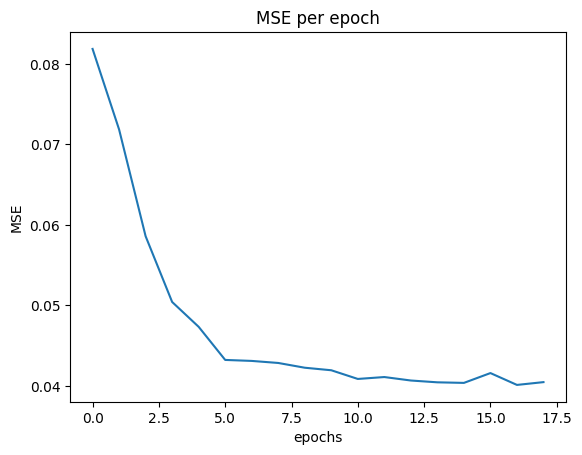

In [5]:
plot_mse('/content/drive/MyDrive/ResearchPaper/Results/train.csv')

In [ ]:
def get_5day_data(data,window_size):
  new_data = []
  for i in tqdm(range(window_size,len(data)-1)):
    window = data.iloc[i-5:i]
    new_data.append(window.values)
  return np.array(new_data)

In [ ]:
btc_5day = get_5day_data(normalized_data,5)
# btc_5day_df = pd.DataFrame(btc_5day,columns = [f'{col}_day_{i+1}' for i in range(5) for col in normalized_data])

100%|██████████| 359/359 [00:00<00:00, 11171.95it/s]


In [ ]:
btc_5day.shape

(359, 5, 6)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

In [ ]:
output = normalized_data['Close'][5:len(normalized_data)-1]

In [ ]:
output.shape

(359,)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 6)]            0         
                                                                 
 sequential_7 (Sequential)   (None, 1)                 9064      
                                                                 
Total params: 9064 (35.41 KB)
Trainable params: 9016 (35.22 KB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(btc_5day , output , batch_size = 16,epochs=3)

Epoch 1/3
23/23 [==============================] - 18s 20ms/step - loss: 0.1843 - mse: 0.1843
Epoch 2/3
23/23 [==============================] - 0s 20ms/step - loss: 0.1579 - mse: 0.1579
Epoch 3/3
23/23 [==============================] - 0s 20ms/step - loss: 0.1594 - mse: 0.1594
